# Diagnostic Analytics - Root Cause Analysis

**Goal:** Conduct Root cause analysis to understand why some pattern exists.

**Questions from Descriptive Analytics Notebook:**
- Why Retention is low? (only 3%)
- Why delays are okay in some category?
- Why geographic location matter?
- What is driving poor reviews apart from delays?

In [1]:
# Setup, Imports, Settings, & Db Connection
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

conn = sqlite3.connect('../data/ecommerce.db')


### 1. Retention Problem - Root Cause Analysis

#### 1.1 Platform Model Analysis

- Hypothesis - Its a marketplace & Ppl buy from sellers not platform - Need to check seller diversity

In [4]:
seller_diversity_query = """
SELECT 
    c.customer_unique_id,
    COUNT(DISTINCT o.order_id) as num_orders,
    COUNT(DISTINCT oi.seller_id) as num_unique_sellers,
    ROUND(AVG(oi.price + oi.freight_value), 2) as avg_order_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_unique_id
HAVING num_orders > 1
"""

repeat_customers = pd.read_sql(seller_diversity_query, conn)

print(f"Repeat Customers Analysis (n = {len(repeat_customers):,}):")
print(f"\nSeller Diversity Among Repeat Customers:")
print(f"  Avg orders per repeat customer: {repeat_customers['num_orders'].mean():.2f}")
print(f"  Avg unique sellers per customer: {repeat_customers['num_unique_sellers'].mean():.2f}")
print(f"  % using same seller: {(repeat_customers['num_orders'] == repeat_customers['num_unique_sellers']).mean() * 100:.1f}%")

print("\n INSIGHT:")
if repeat_customers['num_orders'].mean() - repeat_customers['num_unique_sellers'].mean() < 0.5:
    print("  Even repeat customers use DIFFERENT sellers each time!")
    print("  This confirms: No seller loyalty -> No platform loyalty")
else:
    print("  Repeat customers tend to stick with same sellers")
    print("  Opportunity: Build seller-specific loyalty")

Repeat Customers Analysis (n = 2,801):

Seller Diversity Among Repeat Customers:
  Avg orders per repeat customer: 2.11
  Avg unique sellers per customer: 1.84
  % using same seller: 66.9%

 INSIGHT:
  Even repeat customers use DIFFERENT sellers each time!
  This confirms: No seller loyalty -> No platform loyalty


#### 1.2 Product Mix: One-Off vs Repeat Purchase Categories


Overall Average Repeat Purchase Rate Across Categories: 1.01%
Categories with HIGHEST Repeat Purchase Rates:
                   category  total_customers  repeat_buyers  repeat_rate_pct
0           home_appliances              688             50             7.27
1  fashion_bags_accessories             1757             52             2.96
2            bed_bath_table             9008            245             2.72
3            sports_leisure             7341            170             2.32
4           furniture_decor             6178            126             2.04
5     fashion_male_clothing              104              2             1.92
6     computers_accessories             6405            119             1.86
7                    drinks              282              5             1.77
8     furniture_living_room              407              7             1.72
9             health_beauty             8498            142             1.67

Categories with LOWEST Repeat Purchase Rat

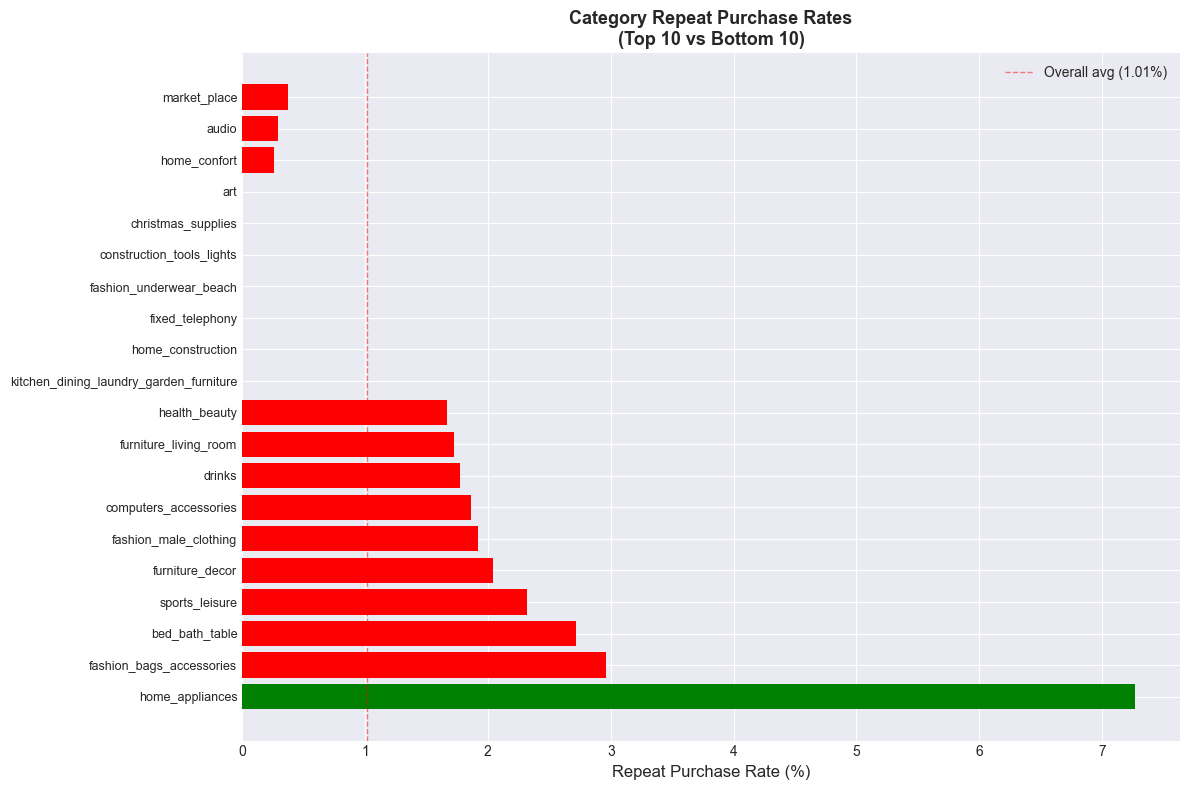

In [8]:
# Categories having low repeat rates:
category_repeat_query = """
WITH customer_category_purchases AS (
    SELECT 
        c.customer_unique_id,
        COALESCE(pct.product_category_name_english, p.product_category_name, 'Unknown') as category,
        COUNT(DISTINCT o.order_id) as purchases_in_category
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN products p ON oi.product_id = p.product_id
    LEFT JOIN product_category_name_translation pct 
        ON p.product_category_name = pct.product_category_name
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id, category
)
SELECT 
    category,
    COUNT(DISTINCT customer_unique_id) as total_customers,
    SUM(CASE WHEN purchases_in_category > 1 THEN 1 ELSE 0 END) as repeat_buyers,
    ROUND(SUM(CASE WHEN purchases_in_category > 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(DISTINCT customer_unique_id), 2) as repeat_rate_pct
FROM customer_category_purchases
GROUP BY category
HAVING total_customers >= 100
ORDER BY repeat_rate_pct DESC
"""

category_repeat = pd.read_sql(category_repeat_query, conn)

# Overall Average
overall_repeat_rate = category_repeat['repeat_rate_pct'].mean()
print(f"\nOverall Average Repeat Purchase Rate Across Categories: {overall_repeat_rate:.2f}%")

print("Categories with HIGHEST Repeat Purchase Rates:")
print(category_repeat.head(10))

print("\nCategories with LOWEST Repeat Purchase Rates:")
print(category_repeat.tail(10))


# Charts
fig, ax = plt.subplots(figsize=(12, 8))

top_bottom = pd.concat([
    category_repeat.nlargest(10, 'repeat_rate_pct'),
    category_repeat.nsmallest(10, 'repeat_rate_pct')
])

colors = ['green' if x > 5 else 'orange' if x > 3 else 'red' for x in top_bottom['repeat_rate_pct']]
ax.barh(range(len(top_bottom)), top_bottom['repeat_rate_pct'], color=colors)
ax.set_yticks(range(len(top_bottom)))
ax.set_yticklabels(top_bottom['category'], fontsize=9)
ax.set_xlabel('Repeat Purchase Rate (%)', fontsize=12)
ax.set_title('Category Repeat Purchase Rates\n(Top 10 vs Bottom 10)', fontsize=13, fontweight='bold')
ax.axvline(overall_repeat_rate, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Overall avg ({overall_repeat_rate:.2f}%)')
ax.legend()

plt.tight_layout()
plt.savefig('../reports/figures/category_repeat_rates.png', dpi=300, bbox_inches='tight')
plt.show()


### 2. Delivery Performance Deep Dive

#### 2.1 Customer - Seller Distance Impact

In [10]:
distance_query = """
WITH order_geography AS (
    SELECT 
        o.order_id,
        c.customer_state,
        s.seller_state,
        CASE 
            WHEN c.customer_state = s.seller_state THEN 'Same State'
            ELSE 'Different State'
        END as location_match,
        JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp) as delivery_days,
        JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_estimated_delivery_date) as delay_days,
        r.review_score
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN sellers s ON oi.seller_id = s.seller_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_customer_date IS NOT NULL
)
SELECT 
    location_match,
    COUNT(*) as num_orders,
    ROUND(AVG(delivery_days), 2) as avg_delivery_days,
    ROUND(AVG(delay_days), 2) as avg_delay_days,
    ROUND(AVG(review_score), 2) as avg_review_score,
    ROUND(SUM(CASE WHEN delay_days > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as delay_rate_pct
FROM order_geography
GROUP BY location_match
ORDER BY num_orders DESC
"""

distance_impact = pd.read_sql(distance_query, conn)

print("Impact of Customer-Seller Geographic Distance:")
print(distance_impact)

# Calculate the impact
if len(distance_impact) == 2:
    same_state = distance_impact[distance_impact['location_match'] == 'Same State'].iloc[0]
    diff_state = distance_impact[distance_impact['location_match'] == 'Different State'].iloc[0]
    
    print("\n KEY FINDINGS:")
    print(f"  Delivery time difference: {diff_state['avg_delivery_days'] - same_state['avg_delivery_days']:.1f} days longer for different state")
    print(f"  Delay rate difference: {diff_state['delay_rate_pct'] - same_state['delay_rate_pct']:.1f}% more delays")
    print(f"  Review impact: {diff_state['avg_review_score'] - same_state['avg_review_score']:.2f} stars")

Impact of Customer-Seller Geographic Distance:
    location_match  num_orders  avg_delivery_days  avg_delay_days  \
0  Different State       70748              15.05          -12.22   
1       Same State       40084               7.93           -9.78   

   avg_review_score  delay_rate_pct  
0              4.02            9.00  
1              4.20            5.95  

 KEY FINDINGS:
  Delivery time difference: 7.1 days longer for different state
  Delay rate difference: 3.0% more delays
  Review impact: -0.18 stars


#### 2.2 Top Routes (Customer <> Seller State)

Top 20 Customer-Seller Routes:
       route  num_orders  avg_delivery_days  avg_review  delay_rate
0   SP <> SP       30829               7.93        4.18        6.08
1   RJ <> SP        8188              16.11        3.79       14.82
2   MG <> SP        7469              12.29        4.07        6.09
3   RS <> SP        3613              16.03        4.02        7.29
4   PR <> SP        3130              12.78        4.08        5.18
5   SP <> PR        2959              11.14        4.19        3.65
6   SP <> MG        2578              10.90        4.17        4.05
7   SC <> SP        2336              15.85        3.93       10.58
8   BA <> SP        2313              19.75        3.80       14.82
9   MG <> MG        1539               8.64        4.31        3.04
10  ES <> SP        1467              15.72        3.98       14.01
11  GO <> SP        1424              15.75        3.99        8.80
12  DF <> SP        1386              13.20        4.00        8.50
13  SP <> RJ     

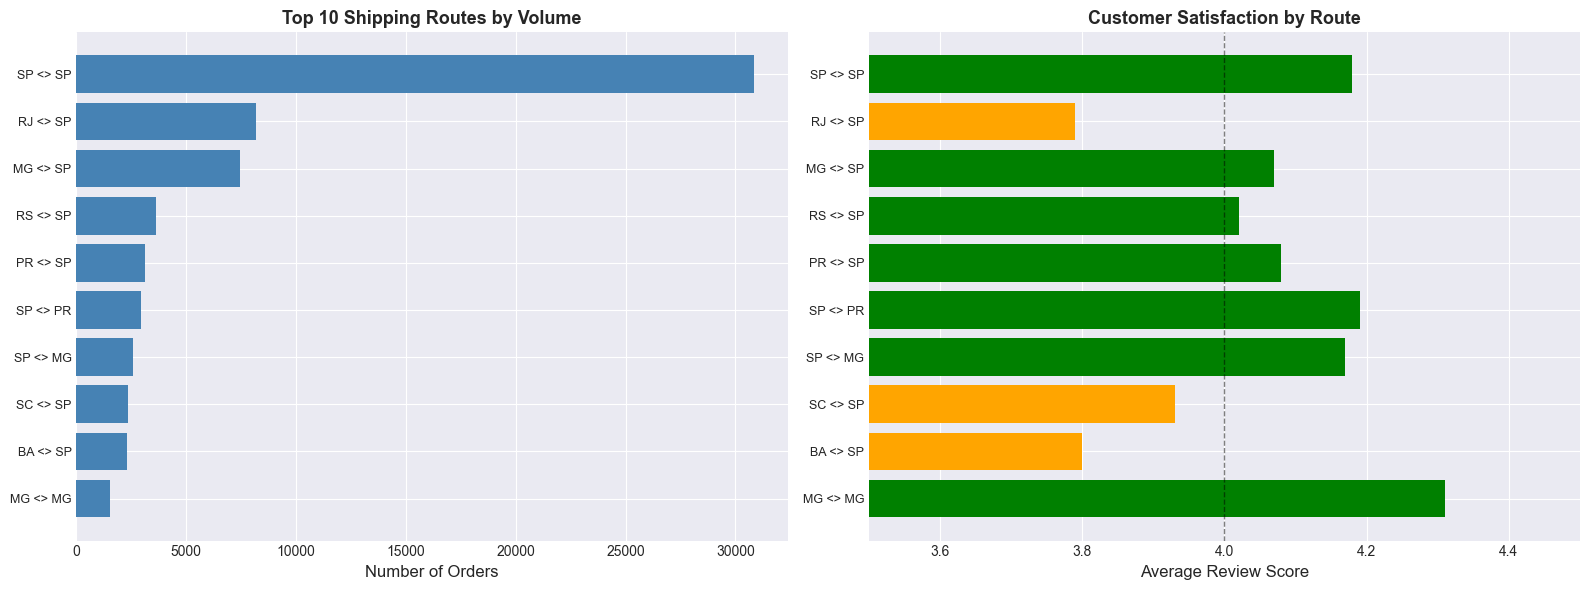

In [13]:
# Detailed route analysis
route_query = """
SELECT 
    c.customer_state as customer_state,
    s.seller_state as seller_state,
    COUNT(DISTINCT o.order_id) as num_orders,
    ROUND(AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp)), 2) as avg_delivery_days,
    ROUND(AVG(r.review_score), 2) as avg_review,
    ROUND(SUM(CASE WHEN JULIANDAY(o.order_delivered_customer_date) > JULIANDAY(o.order_estimated_delivery_date) THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) as delay_rate
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN sellers s ON oi.seller_id = s.seller_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
  AND o.order_delivered_customer_date IS NOT NULL
GROUP BY c.customer_state, s.seller_state
HAVING num_orders >= 50
ORDER BY num_orders DESC
LIMIT 20
"""

routes = pd.read_sql(route_query, conn)
routes['route'] = routes['customer_state'] + ' <> ' + routes['seller_state']

print("Top 20 Customer-Seller Routes:")
print(routes[['route', 'num_orders', 'avg_delivery_days', 'avg_review', 'delay_rate']])

#Charts for routes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top routes by volume
top_10 = routes.head(10)
axes[0].barh(range(len(top_10)), top_10['num_orders'], color='steelblue')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10['route'], fontsize=9)
axes[0].set_xlabel('Number of Orders', fontsize=12)
axes[0].set_title('Top 10 Shipping Routes by Volume', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Delivery performance
colors_perf = ['green' if x >= 4.0 else 'orange' if x >= 3.5 else 'red' for x in top_10['avg_review']]
axes[1].barh(range(len(top_10)), top_10['avg_review'], color=colors_perf)
axes[1].set_yticks(range(len(top_10)))
axes[1].set_yticklabels(top_10['route'], fontsize=9)
axes[1].set_xlabel('Average Review Score', fontsize=12)
axes[1].set_title('Customer Satisfaction by Route', fontsize=13, fontweight='bold')
axes[1].axvline(4.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1].invert_yaxis()
axes[1].set_xlim(3.5, 4.5)

plt.tight_layout()
plt.savefig('../reports/figures/shipping_routes_analysis.png', dpi=300, bbox_inches='tight')
plt.show()